# Creation of transformed (FDA) patches dataset

Here is the code for the creation of multiple datasets to analyse the performances of AI models on the data transformed by Fourier Domain Adaptation. Three values of the hyperparameter defining the amount of style transfert will be tested: 0.01, 0.02, 0.05. The datasets will be under deeplake format.

## Requirements 


### Modules 


In [1]:
import deeplake
import numpy as np
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from functools import partial 
from tqdm import tqdm 

### FDA functions

In [4]:
# ----------- Fourier Domain Adaptation (with clipping + uint8 conversion) -------------
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def modif_FDA_source_to_target_np(src_img, amp_trg, L=0.1):
    fft_src_np = np.fft.fft2(src_img, axes=(-2, -1))
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_src_ = low_freq_mutate_np(amp_src, amp_trg, L=L)
    fft_src_ = amp_src_ * np.exp(1j * pha_src)
    src_in_trg = np.fft.ifft2(fft_src_, axes=(-2, -1))
    src_in_trg = np.real(src_in_trg)

    # Clip and convert to uint8
    src_in_trg = np.clip(src_in_trg, 0, 255).astype(np.uint8)
    return src_in_trg




## Dataset generation

In [4]:
# -------------------- Configuration --------------------------
output_root = "/home/leolr-int/transformed_data/KFBio"
input_root = "/home/leolr-int/data/data/patched/dim_256/Train"
general_average = np.load("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy")

L_values = [0.01, 0.02, 0.05]
label_map = {0: "stroma", 1: "normal", 2: "G3", 3: "G4", 4: "G5"}

# quick test to generate only five pics
test_mode = False
max_patches = 5
subset_id = 1  



In [75]:
# Save function to run in parallel
def save_transformed_patch(L_val, source_image, label_name, filename, output_root, general_average):
    transformed = modif_FDA_source_to_target_np(source_image, general_average, L=L_val)
    transformed_img = transformed.transpose((1, 2, 0))
    save_path = os.path.join(output_root, f"L_{L_val:.2f}", label_name)
    os.makedirs(save_path, exist_ok=True)
    Image.fromarray(transformed_img).save(os.path.join(save_path, filename))


creation = False
if creation:
    subset_range = [subset_id] if test_mode else list(range(1, 27))

    for i in subset_range:
        dataset_path = f"{input_root}/Subset3_Train_{i}_KFBio"
        KFBio = deeplake.open_read_only(dataset_path)
        print(f"\nProcessing Subset {i}...")

        num_patches = min(len(KFBio), max_patches) if test_mode else len(KFBio)

        for j in range(num_patches):
            source_image = KFBio[j]["patch"].transpose((2, 0, 1))  # (3, H, W)
            label_index = int(KFBio[j]["label"])
            label_name = label_map[label_index]
            # Generate UUID-based filename
            #filename = f"{uuid.uuid4().hex}.tiff"
            filename = f"Subset3_Train_{i}_patch_{j}.tiff"

            # Save unmodified
            unmod_img = np.clip(source_image, 0, 255).astype(np.uint8).transpose((1, 2, 0))
            save_path = os.path.join(output_root, "unmodified", label_name)
            os.makedirs(save_path, exist_ok=True)
            Image.fromarray(unmod_img).save(os.path.join(save_path, filename))

            # Save transformed versions in parallel
            with ProcessPoolExecutor(max_workers=3) as executor:
                executor.map(partial(
                    save_transformed_patch,
                    source_image=source_image,
                    label_name=label_name,
                    filename=filename,
                    output_root=output_root,
                    general_average=general_average
                ), L_values)


    print("✅ Dataset transformation complete.")

## Testing the dataset creation

In [5]:
L_values = ["L_0.01", "L_0.02", "L_0.05", "unmodified"]
labels = ["stroma", "normal", "G3", "G4", "G5"]
for L_tag in L_values:
    print(f"--- {L_tag} ---")
    total = 0
    for label in labels:
        folder = os.path.join(output_root, L_tag, label)
        if not os.path.exists(folder):
            print(f"  ⚠️  Missing folder: {folder}")
            continue
        tiff_files = [f for f in os.listdir(folder) if f.endswith(".tiff")]
        print(f"  {label}: {len(tiff_files)} images")
        total += len(tiff_files)

    print(f"  ✅ Total in {L_tag}: {total} images\n")

--- L_0.01 ---
  stroma: 35271 images
  normal: 18350 images
  G3: 55964 images
  G4: 87100 images
  G5: 782 images
  ✅ Total in L_0.01: 197467 images

--- L_0.02 ---
  stroma: 35271 images
  normal: 18350 images
  G3: 55964 images
  G4: 87100 images
  G5: 782 images
  ✅ Total in L_0.02: 197467 images

--- L_0.05 ---
  stroma: 35271 images
  normal: 18350 images
  G3: 55964 images
  G4: 87100 images
  G5: 782 images
  ✅ Total in L_0.05: 197467 images

--- unmodified ---
  stroma: 35271 images
  normal: 18350 images
  G3: 55964 images
  G4: 87100 images
  G5: 782 images
  ✅ Total in unmodified: 197467 images



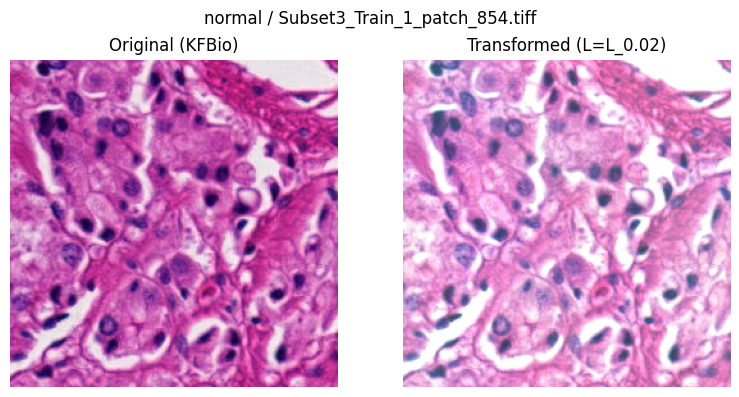

Displayed: Subset3_Train_1_patch_854.tiff


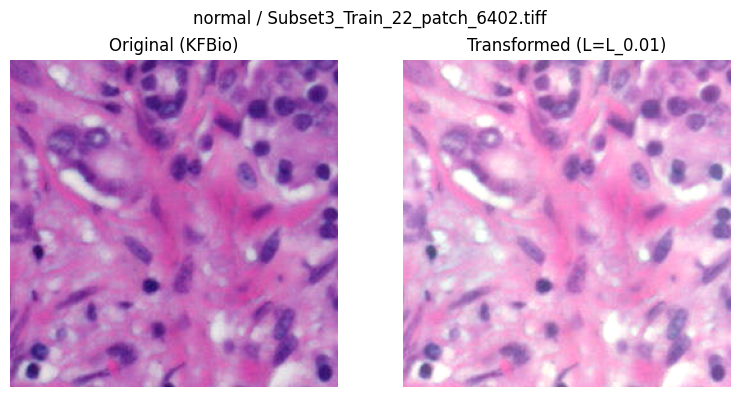

Displayed: Subset3_Train_22_patch_6402.tiff


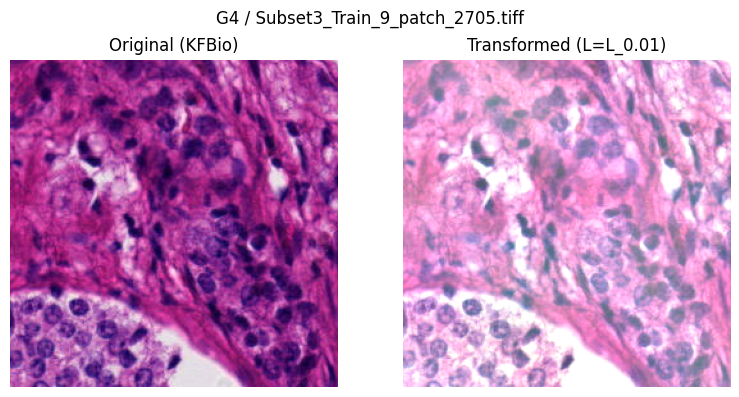

Displayed: Subset3_Train_9_patch_2705.tiff


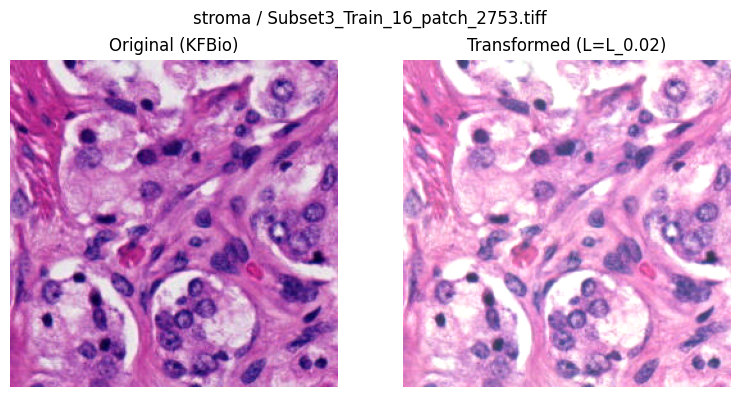

Displayed: Subset3_Train_16_patch_2753.tiff


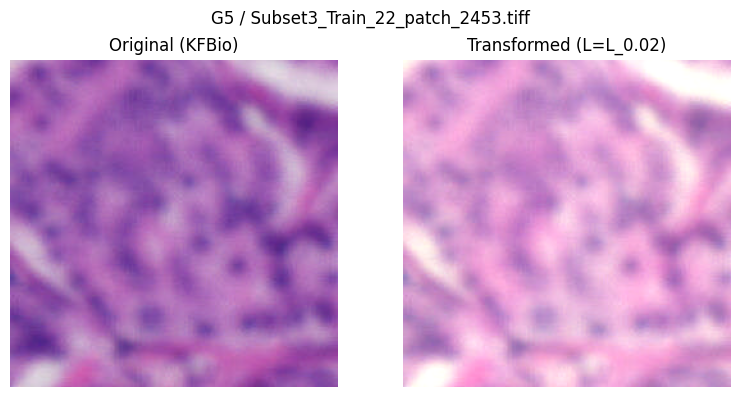

Displayed: Subset3_Train_22_patch_2453.tiff


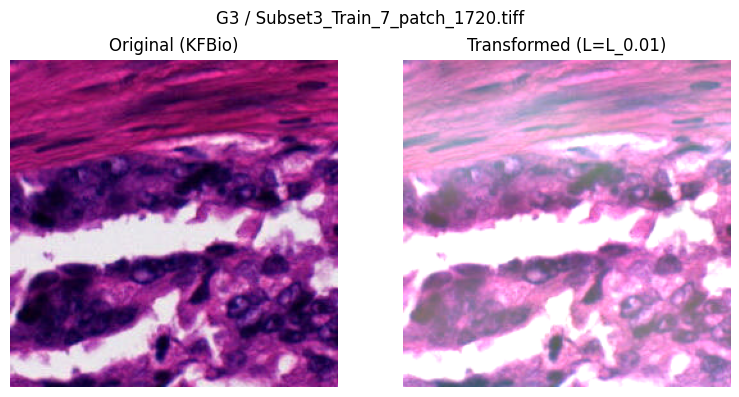

Displayed: Subset3_Train_7_patch_1720.tiff


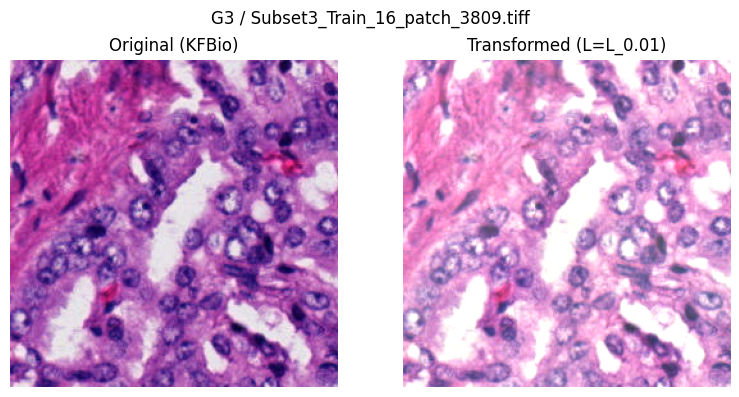

Displayed: Subset3_Train_16_patch_3809.tiff


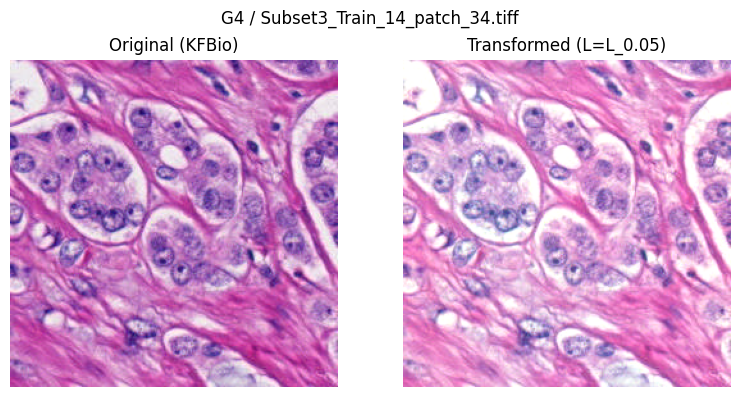

Displayed: Subset3_Train_14_patch_34.tiff


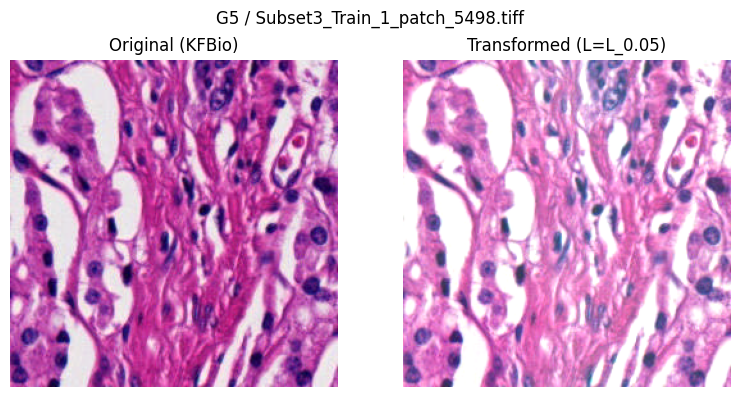

Displayed: Subset3_Train_1_patch_5498.tiff


In [9]:
# Random selection of data


# Path to your transformed data
output_root = "/home/leolr-int/transformed_data/KFBio"
#example_folder = os.path.join(output_root, "L_0.01", "G4")

# Show example image using matplotlib (Jupyter-friendly)
output_root = "/home/leolr-int/transformed_data/KFBio"

for i in range(1,10):

    L = random.choice(["L_0.01", "L_0.02", "L_0.05"])
    label = random.choice(labels)
    transformed_folder = os.path.join(output_root, "L_0.01", "G4")
    unmodified_folder = os.path.join(output_root, "unmodified", "G4")

    # Show example transformed vs original
    show_example = True
    if show_example:
        if os.path.exists(transformed_folder) and os.path.exists(unmodified_folder):
            files = [f for f in os.listdir(transformed_folder) if f.endswith(".tiff")]
            if files:
                filename = random.choice(files)

                # Load transformed and unmodified
                transformed_path = os.path.join(transformed_folder, filename)
                unmodified_path = os.path.join(unmodified_folder, filename)

                if not os.path.exists(unmodified_path):
                    print(f"⚠️ Matching unmodified file not found: {unmodified_path}")
                else:
                    img_transformed = Image.open(transformed_path)
                    img_unmodified = Image.open(unmodified_path)

                    # Plot side by side
                    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                    axs[0].imshow(img_unmodified)
                    axs[0].set_title("Original (KFBio)")
                    axs[0].axis('off')

                    axs[1].imshow(img_transformed)
                    axs[1].set_title(f"Transformed (L={L})")
                    axs[1].axis('off')

                    plt.suptitle(f"{label} / {filename}", fontsize=12)
                    plt.tight_layout()
                    plt.show()

                    print(f"Displayed: {filename}")
            else:
                print("⚠️ No images found in transformed folder.")
        else:
            print(f"⚠️ One of the folders does not exist:\n  {transformed_folder}\n  {unmodified_folder}")

## Creation of the deeplake dataset

In [ ]:


def create_transformed_dataset(L_val, input_ds_path, output_root, general_average, max_patches=None): # Open source dataset src_ds = deeplake.open_read_only(input_ds_path) 

    # Create output dataset 
    dest_path = os.path.join(output_root, f"deeplake_L_{L_val:.2f}") 
    os.makedirs(dest_path, exist_ok=True) 
    new_ds = deeplake.create(dest_path) 
    
    # Define columns to match the original 
    new_ds.add_column("patch", dtype=deeplake.types.Image(sample_compression="png")) 
    new_ds.add_column("label", dtype=deeplake.types.Int32) 
    new_ds.add_column("area", dtype=deeplake.types.Int32) 
    new_ds.add_column("x", dtype=deeplake.types.Int32) 
    new_ds.add_column("y", dtype=deeplake.types.Int32) 
    new_ds.add_column("w", dtype=deeplake.types.Int32) 
    new_ds.add_column("h", dtype=deeplake.types.Int32) 
    new_ds.add_column("img_idx", dtype=deeplake.types.Int32) 
    
    # Loop over patches 
    n = len(src_ds) if max_patches is None else min(len(src_ds), max_patches) 
    for j in tqdm(range(n), desc=f"L={L_val:.2f}"): 
        sample = src_ds[j] 
        patch = sample["patch"].numpy() 
        patch = patch.transpose((2, 0, 1))  # (C, H, W) 
    
        # Apply transformation 
        transformed = modif_FDA_source_to_target_np(patch, general_average, L=L_val) 
        transformed = np.clip(transformed, 0, 255).astype(np.uint8).transpose((1, 2, 0))  # (H, W, C) 
    
        # Append to dataset 
        new_ds.append([{ 
            "patch": transformed, 
            "label": int(sample["label"]), 
            "area": int(sample["area"]), 
            "x": int(sample["x"]), 
            "y": int(sample["y"]), 
            "w": int(sample["w"]), 
            "h": int(sample["h"]), 
            "img_idx": int(sample["img_idx"]) 
        }]) 
    
    new_ds.flush() 
    print(f"✅ Saved transformed DeepLake dataset for L={L_val:.2f} at {dest_path}") 
    

#Example 

input_ds_path = "/path/to/KFBio/Subset3_Train_7" 
output_root = "/output/transformed_deeplake" 
general_average = ... # your precomputed mean image L_values = [0.05, 0.1, 0.3] 

for L_val in L_values: create_transformed_dataset(L_val, input_ds_path, output_root, general_average, max_patches=1000) 

 

In [14]:
# TODO: add random visualisation and check the number of files
def create_transformed_dataset(L_val, input_root, output_root, general_average, max_patches=None, test_mode=False, subset_id=1):
    """
    Create a transformed dataset using FDA transformation
    Process multiple subsets based on test_mode
    """
    try:
        # Determine which subsets to process
        subset_range = [subset_id] if test_mode else list(range(1, 27))
        
        # Create output dataset
        dest_path = os.path.join(output_root, f"{L_val}")
        os.makedirs(dest_path, exist_ok=True)
    
        
        new_ds = deeplake.create(dest_path)
        
        # Define columns to match the original
        new_ds.add_column("patch", dtype=deeplake.types.Image(sample_compression="png"))
        new_ds.add_column("label", dtype=deeplake.types.Int32)
        new_ds.add_column("area", dtype=deeplake.types.Int32)
        new_ds.add_column("x", dtype=deeplake.types.Int32)
        new_ds.add_column("y", dtype=deeplake.types.Int32)
        new_ds.add_column("w", dtype=deeplake.types.Int32)
        new_ds.add_column("h", dtype=deeplake.types.Int32)
        #new_ds.add_column("img_idx", dtype=deeplake.types.Int32)
        new_ds.add_column("subset_id", dtype=deeplake.types.Int32)  # Added to track which subset
        
        total_processed = 0
        
        # Loop over subsets
        for i in subset_range:
            dataset_path = f"{input_root}/Subset3_Train_{i}_KFBio"
            
            try:
                KFBio = deeplake.open_read_only(dataset_path)
                print(f"\nProcessing Subset {i}...")
                
                # Determine number of patches to process
                num_patches = min(len(KFBio), max_patches) if test_mode else len(KFBio)
                
                print(f"Processing {num_patches} patches from Subset {i}")
                
                # Loop over patches in current subset
                for j in tqdm(range(num_patches), desc=f"Subset {i}, L={L_val}"):
                    sample = KFBio[j]
                    source_image = sample["patch"]
                    
                    # Ensure patch is in correct format (3, H, W)
                    if len(source_image.shape) == 3:
                        if source_image.shape[2] == 3:  # (H, W, C)
                            source_image = source_image.transpose((2, 0, 1))  # Convert to (C, H, W)
                        # If already (C, H, W), keep as is
                    else:
                        raise ValueError(f"Unexpected patch shape: {source_image.shape}")
                    
                    # Apply transformation
                    transformed = modif_FDA_source_to_target_np(source_image, general_average, L=L_val)
                    transformed = np.clip(transformed, 0, 255).astype(np.uint8)
                    
                    # Ensure output is (H, W, C) for storage
                    if transformed.shape[0] == 3:  # If (C, H, W)
                        transformed = transformed.transpose((1, 2, 0))  # Convert to (H, W, C)
                    
                    # Append to dataset
                    new_ds.append([{
                        "patch": transformed,
                        "label": int(sample["label"]),
                        "area": int(sample["area"]),
                        "x": int(sample["x"]),
                        "y": int(sample["y"]),
                        "w": int(sample["w"]),
                        "h": int(sample["h"]),
                        
                        "subset_id": int(i)  # Track which subset this came from
                    }])
                    #"img_idx": int(sample["img_idx"]),
                    # i removed this, if needed check the file patch_idx from Eric
                    
                    total_processed += 1
                
                print(f"✅ Completed Subset {i}: {num_patches} patches processed")
                
            except Exception as e:
                print(f"❌ Error processing Subset {i}: {str(e)}")
                continue
        
        # new_ds.flush()
        print(f"✅ Saved transformed DeepLake dataset for L={L_val} at {dest_path}")
        print(f"📊 Total patches processed: {total_processed}")
        return True
        
    except Exception as e:
        print(f"❌ Error in create_transformed_dataset for L={L_val}: {str(e)}")
        return False


# Test configuration - only 5 files for testing
def run_test():
    input_root = "/home/leolr-int/data/data/patched/dim_256/Train"  # Root directory containing all subsets
    output_root = "/home/leolr-int/transformed_data/deeplake_datasets"
    general_average = np.load("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy")

    
    # Test with only 5 files and single L value
    L_values = [0.01]  # Only L = 0.01 for testing
    max_patches_test = 5  # Only 5 patches for testing
    test_mode = True  # Enable test mode
    subset_id = 1  # Test with only Subset 1
    
    print("🧪 Starting test run with 5 files and L = 0.01...")
    
    successful_runs = []
    failed_runs = []
    
    for L_val in L_values:
        print(f"\n📊 Testing L={L_val}")
        success = create_transformed_dataset(
            L_val, 
            input_root, 
            output_root, 
            general_average, 
            max_patches=max_patches_test,
            test_mode=test_mode,
            subset_id=subset_id
        )
        
        if success:
            successful_runs.append(L_val)
        else:
            failed_runs.append(L_val)
    
    # Summary
    print(f"\n📈 Test Summary:")
    print(f"✅ Successful runs: {len(successful_runs)} - L values: {successful_runs}")
    print(f"❌ Failed runs: {len(failed_runs)} - L values: {failed_runs}")
    
    if len(failed_runs) == 0:
        print("🎉 All tests passed! You can now run with full dataset.")
    else:
        print("⚠️  Some tests failed. Please check the errors above.")




# Production run function
def run_production():
    input_root = "/home/leolr-int/data/data/patched/dim_256/Train"  # Root directory containing all subsets
    output_root = "/home/leolr-int/transformed_data/deeplake_datasets"
    general_average = np.load("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy")

    L_values = [0.01]  # Only L = 0.01
    
    creation = True  # Set to True to enable processing
    
    if creation:
        for L_val in L_values:
            print(f"\n🚀 Starting production run for L={L_val}")
            success = create_transformed_dataset(
                L_val, 
                input_root, 
                output_root, 
                general_average, 
                max_patches=None,  # Process all patches
                test_mode=False,   # Process all subsets (1-26)
                subset_id=1        # Not used when test_mode=False
            )
            
            if success:
                print(f"✅ Production run completed successfully for L={L_val}")
            else:
                print(f"❌ Production run failed for L={L_val}")

# Run the test
'''if __name__ == "__main__":
    run_test()'''
    
    # Uncomment the line below to run production after successful test
    # run_production()

# Full production run (uncomment to use after successful test)

# Example usage:
input_root = "/home/leolr-int/data/data/patched/dim_256/Train"  # Root directory containing all subsets
output_root = "/home/leolr-int/transformed_data/deeplake_datasets"
general_average = np.load("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy")

L_values = [0.01]  # Only L = 0.01

creation = True
if creation:
    for L_val in L_values:
        create_transformed_dataset(
            L_val, 
            input_root, 
            output_root, 
            general_average, 
            max_patches=None,  # Process all patches
            test_mode=False,   # Process all subsets (1-26)
            subset_id=1        # Not used when test_mode=False
        )



Processing Subset 1...
Processing 11605 patches from Subset 1


Subset 1, L=0.01:   0%|          | 0/11605 [00:00<?, ?it/s]

Subset 1, L=0.01: 100%|██████████| 11605/11605 [05:42<00:00, 33.89it/s]


✅ Completed Subset 1: 11605 patches processed

Processing Subset 2...
Processing 12793 patches from Subset 2


Subset 2, L=0.01: 100%|██████████| 12793/12793 [06:32<00:00, 32.57it/s]


✅ Completed Subset 2: 12793 patches processed

Processing Subset 3...
Processing 6534 patches from Subset 3


Subset 3, L=0.01: 100%|██████████| 6534/6534 [03:19<00:00, 32.74it/s]


✅ Completed Subset 3: 6534 patches processed

Processing Subset 4...
Processing 5174 patches from Subset 4


Subset 4, L=0.01: 100%|██████████| 5174/5174 [02:31<00:00, 34.19it/s]


✅ Completed Subset 4: 5174 patches processed

Processing Subset 5...
Processing 2503 patches from Subset 5


Subset 5, L=0.01: 100%|██████████| 2503/2503 [01:12<00:00, 34.32it/s]


✅ Completed Subset 5: 2503 patches processed

Processing Subset 6...
Processing 8055 patches from Subset 6


Subset 6, L=0.01: 100%|██████████| 8055/8055 [04:08<00:00, 32.38it/s]


✅ Completed Subset 6: 8055 patches processed

Processing Subset 7...
Processing 14752 patches from Subset 7


Subset 7, L=0.01: 100%|██████████| 14752/14752 [07:42<00:00, 31.91it/s]


✅ Completed Subset 7: 14752 patches processed

Processing Subset 8...
Processing 7072 patches from Subset 8


Subset 8, L=0.01: 100%|██████████| 7072/7072 [03:40<00:00, 32.13it/s]


✅ Completed Subset 8: 7072 patches processed

Processing Subset 9...
Processing 5247 patches from Subset 9


Subset 9, L=0.01: 100%|██████████| 5247/5247 [02:39<00:00, 32.89it/s]


✅ Completed Subset 9: 5247 patches processed

Processing Subset 10...
Processing 383 patches from Subset 10


Subset 10, L=0.01: 100%|██████████| 383/383 [00:11<00:00, 33.94it/s]


✅ Completed Subset 10: 383 patches processed

Processing Subset 11...
Processing 3699 patches from Subset 11


Subset 11, L=0.01: 100%|██████████| 3699/3699 [01:48<00:00, 34.22it/s]


✅ Completed Subset 11: 3699 patches processed

Processing Subset 12...
Processing 18652 patches from Subset 12


Subset 12, L=0.01: 100%|██████████| 18652/18652 [10:00<00:00, 31.07it/s]


✅ Completed Subset 12: 18652 patches processed

Processing Subset 13...
Processing 4433 patches from Subset 13


Subset 13, L=0.01: 100%|██████████| 4433/4433 [02:11<00:00, 33.60it/s]


✅ Completed Subset 13: 4433 patches processed

Processing Subset 14...
Processing 5517 patches from Subset 14


Subset 14, L=0.01: 100%|██████████| 5517/5517 [02:41<00:00, 34.08it/s]


✅ Completed Subset 14: 5517 patches processed

Processing Subset 15...
Processing 3556 patches from Subset 15


Subset 15, L=0.01: 100%|██████████| 3556/3556 [01:45<00:00, 33.56it/s]


✅ Completed Subset 15: 3556 patches processed

Processing Subset 16...
Processing 13095 patches from Subset 16


Subset 16, L=0.01: 100%|██████████| 13095/13095 [06:41<00:00, 32.58it/s]


✅ Completed Subset 16: 13095 patches processed

Processing Subset 17...
Processing 6824 patches from Subset 17


Subset 17, L=0.01: 100%|██████████| 6824/6824 [03:23<00:00, 33.47it/s]


✅ Completed Subset 17: 6824 patches processed

Processing Subset 18...
Processing 5096 patches from Subset 18


Subset 18, L=0.01: 100%|██████████| 5096/5096 [02:27<00:00, 34.48it/s]


✅ Completed Subset 18: 5096 patches processed

Processing Subset 19...
Processing 3036 patches from Subset 19


Subset 19, L=0.01: 100%|██████████| 3036/3036 [01:28<00:00, 34.49it/s]


✅ Completed Subset 19: 3036 patches processed

Processing Subset 20...
Processing 1574 patches from Subset 20


Subset 20, L=0.01: 100%|██████████| 1574/1574 [00:46<00:00, 33.90it/s]


✅ Completed Subset 20: 1574 patches processed

Processing Subset 21...
Processing 6524 patches from Subset 21


Subset 21, L=0.01: 100%|██████████| 6524/6524 [03:14<00:00, 33.62it/s]


✅ Completed Subset 21: 6524 patches processed

Processing Subset 22...
Processing 10299 patches from Subset 22


Subset 22, L=0.01: 100%|██████████| 10299/10299 [04:55<00:00, 34.89it/s]


✅ Completed Subset 22: 10299 patches processed

Processing Subset 23...
Processing 10948 patches from Subset 23


Subset 23, L=0.01: 100%|██████████| 10948/10948 [05:40<00:00, 32.14it/s]


✅ Completed Subset 23: 10948 patches processed

Processing Subset 24...
Processing 3146 patches from Subset 24


Subset 24, L=0.01: 100%|██████████| 3146/3146 [01:37<00:00, 32.29it/s]


✅ Completed Subset 24: 3146 patches processed

Processing Subset 25...
Processing 10714 patches from Subset 25


Subset 25, L=0.01: 100%|██████████| 10714/10714 [05:31<00:00, 32.33it/s]


✅ Completed Subset 25: 10714 patches processed

Processing Subset 26...
Processing 16236 patches from Subset 26


Subset 26, L=0.01: 100%|██████████| 16236/16236 [08:41<00:00, 31.12it/s]


✅ Completed Subset 26: 16236 patches processed
✅ Saved transformed DeepLake dataset for L=0.01 at /home/leolr-int/transformed_data/deeplake_datasets/0.01
📊 Total patches processed: 197467


Original dataset size: 5174 samples
Transformed dataset size: 197467 samples
Sample 3118: Label=2, Area=62768, Shape=(256, 256, 3)
Sample 4944: Label=2, Area=65536, Shape=(256, 256, 3)
Sample 3353: Label=2, Area=39550, Shape=(256, 256, 3)


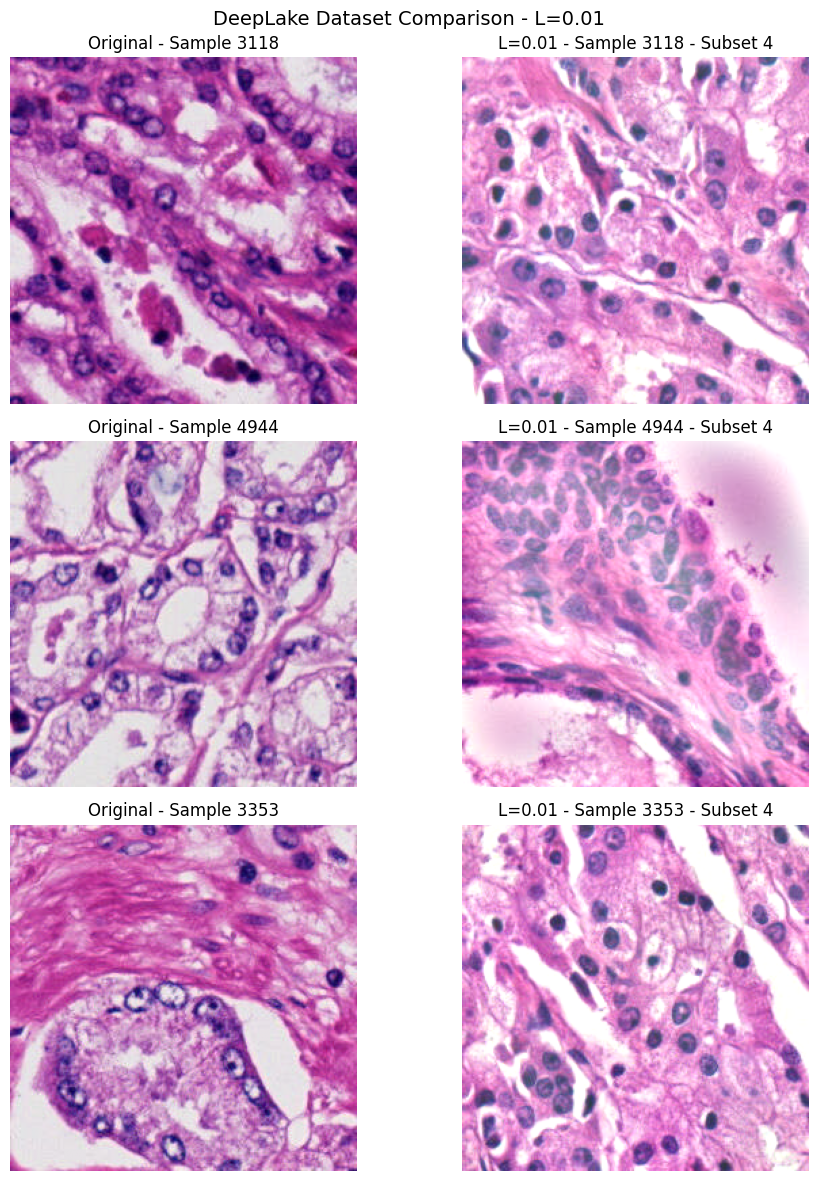

In [25]:
# checking if everything is alright

# Configuration
input_root = "/home/leolr-int/data/data/patched/dim_256/Train"  # Root directory containing all subsets
output_root = "/home/leolr-int/transformed_data/deeplake_datasets"
    
L_val = 0.01
subset_id = 4
num_examples = 3

# Dataset paths
original_ds_path = f"{input_root}/Subset3_Train_{subset_id}_KFBio"
transformed_ds_path = os.path.join(output_root, f"0.01")

# Open both datasets
original_ds = deeplake.open_read_only(original_ds_path)
transformed_ds = deeplake.open_read_only(transformed_ds_path)

print(f"Original dataset size: {len(original_ds)} samples")
print(f"Transformed dataset size: {len(transformed_ds)} samples")

# Get available indices
max_samples = min(len(original_ds), len(transformed_ds))
sample_indices = random.sample(range(max_samples), min(num_examples, max_samples))

# Create subplots
fig, axes = plt.subplots(num_examples, 2, figsize=(10, 4 * num_examples))
if num_examples == 1:
   axes = axes.reshape(1, -1)

for i, idx in enumerate(sample_indices):
   # Get samples from both datasets
   original_sample = original_ds[idx]
   transformed_sample = transformed_ds[idx]
   
   # Extract patches
   original_patch = original_sample["patch"]
   transformed_patch = transformed_sample["patch"]
   
   # Ensure patches are in (H, W, C) format for display
   if original_patch.shape[0] == 3:  # (C, H, W)
       original_patch = original_patch.transpose((1, 2, 0))
   if transformed_patch.shape[0] == 3:  # (C, H, W)
       transformed_patch = transformed_patch.transpose((1, 2, 0))
   
   # Normalize to [0, 1] for display
   original_patch = np.clip(original_patch / 255.0, 0, 1)
   transformed_patch = np.clip(transformed_patch / 255.0, 0, 1)
   
   # Display original
   axes[i, 0].imshow(original_patch)
   axes[i, 0].set_title(f"Original - Sample {idx}")
   axes[i, 0].axis('off')
   
   # Display transformed
   axes[i, 1].imshow(transformed_patch)
   axes[i, 1].set_title(f"L={L_val} - Sample {idx} - Subset {subset_id}")
   axes[i, 1].axis('off')
   
   # Print sample info
   print(f"Sample {idx}: Label={original_sample['label']}, Area={original_sample['area']}, Shape={original_patch.shape}")

plt.suptitle(f"DeepLake Dataset Comparison - L={L_val}", fontsize=14)
plt.tight_layout()
plt.show()